# Report for the Multi Agent Project

By: Daniel Nehren
Date: 7/13/2020

The folowing report provides the details on the solution of the Multi Agent project.
The project task is to build Agent to solve the Tennis Environment playing against itself. 

### Tennis Unity Environment Details:

In this environment, two agents control rackets to bounce a ball over a net. 
If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

Solving the environment consists in achieving an average score of average score of +0.5 over 100 consecutive episodes, after taking the maximum over both agents.

### Learning Algorithm

The proposed agent is a version of a MADDPG agent as presented in the paper: [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf)

#### Agent Details

The agent is a variation of a DDPG Agent with a few important differences. The most important one is that the Critic used during training is leveraging all the information across the 2 agents share the combinet state and action spaces

Ther actor uses a standard 3 layer network using Relu activation for internal layers and a tanh activation to ensure output is between -1 and +1
The  critic network uses the typical setup for DDPG with a standard input layer and the internal layer that contatenates both full state and  full action action to output the estimate of the Q function.

The netwroks sizes are:
```python
config.ACTOR_FC1_UNITS = 265
config.ACTOR_FC2_UNITS = 128
config.CRITIC_FC1_UNITS = 256
config.CRITIC_FC2_UNITS = 128

```

The optimizers used for both networks is Adam with learning rates:
```python
config.LR_ACTOR = 1e-4
config.LR_CRITIC = 3e-4
```

We use target networks for both actor & critic. And they are updated via sof synch with:
```python
config.TAU = 1e-3
```

The replay buffer and batch sizes are as follows:
```python
config.BUFFER_SIZE = int(1e5)
config.BATCH_SIZE = 256
```

The actor network generate deterministic actions and noise is added in order to encourage exploration. Instead of the standard Ornstein–Uhlenbeck process I used a gaussian normal random innovation with 0 mean and 0.5 standard deviation. The amount of noise is decayed down over time to a min multiplier:
```python
config.NOISE_START=1.0
config.NOISE_END=0.1
config.NOISE_REDUCTION=0.999

```

#### Training

We prime the buffer with 300 Epochs before starting to train in order to accumulate sufficient experiences.
For every iteration I run 3 consecutive training steps.

### Solution Details

The environmet was solved in 4820 episodes with an avg score of 0.501

I want to aknoweldge Amit Patel's excellent [Medium Article](https://medium.com/@amitpatel.gt/maddpg-91caa221d75e) for ideas and inspiration as we asl for validating my own implementation. This allowed me to identify a subtle bug in my original implementation. 


In [2]:
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import sys
import torch
import ptan

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Training Process Plots

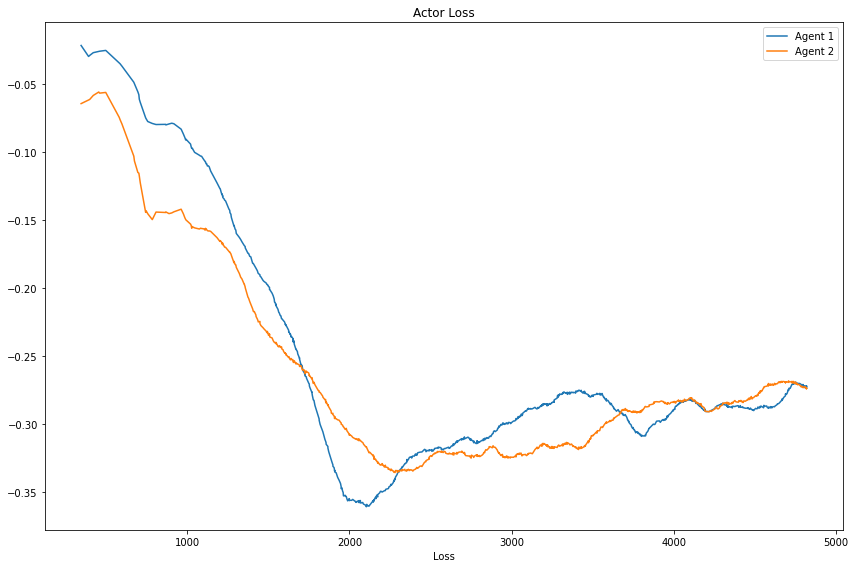

In [3]:
actor_loss_0 = pd.read_csv('./loss_actor_0.csv')
actor_loss_0 = actor_loss_0.set_index('Step')
actor_loss_1 = pd.read_csv('./loss_actor_1.csv')
actor_loss_1 = actor_loss_1.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = actor_loss_0.Value.plot()
_ = actor_loss_1.Value.plot()
_ = plt.legend(['Agent 1','Agent 2'])
_ = plt.xlabel('Episode')
_ = plt.xlabel('Loss')
_ = plt.title('Actor Loss')
plt.tight_layout()
plt.show()

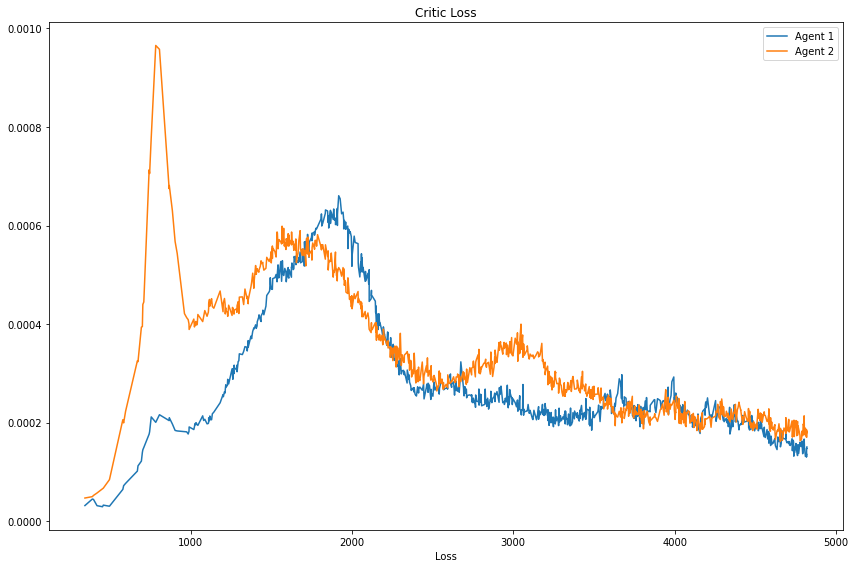

In [4]:
critic_loss_0 = pd.read_csv('./loss_critic_0.csv')
critic_loss_0 = critic_loss_0.set_index('Step')
critic_loss_1 = pd.read_csv('./loss_critic_1.csv')
critic_loss_1 = critic_loss_1.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = critic_loss_0.Value.plot()
_ = critic_loss_1.Value.plot()
_ = plt.legend(['Agent 1','Agent 2'])
_ = plt.xlabel('Episode')
_ = plt.xlabel('Loss')
_ = plt.title('Critic Loss')
plt.tight_layout()
plt.show()

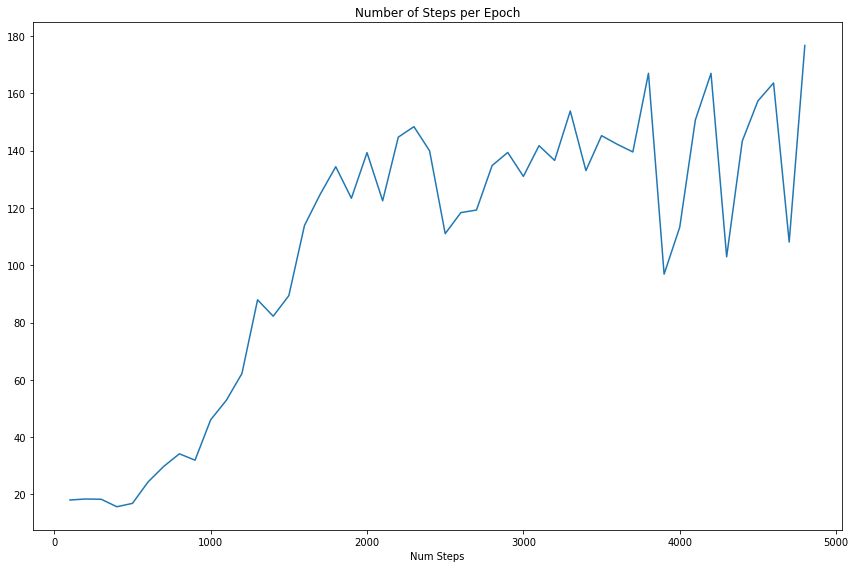

In [5]:
num_steps = pd.read_csv('./num_steps.csv')
num_steps = num_steps.set_index('Step')

fig, ax = plt.subplots(figsize=(12,8))
_ = num_steps.Value.plot()
_ = plt.xlabel('Episode')
_ = plt.xlabel('Num Steps')
_ = plt.title('Number of Steps per Epoch')
plt.tight_layout()
plt.show()

Last 100 Epochs Avg Score = 0.501


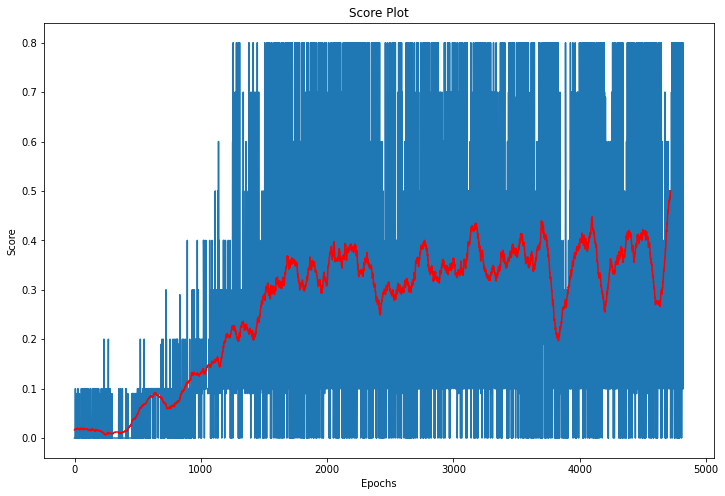

In [33]:
score_list = np.load('./score_list.npy')
m_scores = []
for i in range(101,len(score_list)):
    m_scores.append(score_list[i-100:i].mean())
    
print(f'Last 100 Epochs Avg Score = {score_list[-100:].mean():2.3f}')
fig, ax = plt.subplots(figsize = (12,8))
_ = plt.plot(score_list)
_ = plt.plot(m_scores,c='r')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Score")
_ = plt.title("Score Plot")
plt.show()

### Demonstrating Solution

In [7]:
from maddpg_model import Config,Actor,Critic,ReplayBuffer,MADDPGAgent

In [8]:
env = UnityEnvironment(file_name='Tennis.app',no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [11]:
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = env_info.previous_vector_actions.shape[0]

In [18]:
config = Config()
config.ACTOR_FC1_UNITS = 265
config.ACTOR_FC2_UNITS = 128
config.CRITIC_FC1_UNITS = 256
config.CRITIC_FC2_UNITS = 128
config.LR_ACTOR = 1e-4
config.LR_CRITIC = 3e-4
config.WEIGHT_DECAY = 0
config.TAU = 1e-3
config.DEVICE='cpu'
config.NOISE_START=1.0
config.NOISE_END=0.1
config.NOISE_REDUCTION=0.999

In [19]:
agents = [MADDPGAgent(state_size,action_size,n_agents,config) for _ in range(n_agents)]

In [20]:
model = torch.load('./solved_state.ckp')

In [21]:
model.keys()

dict_keys(['epoch', 'score_list', 'actor_0', 'critic_0', 'actor_opt_0', 'critic_opt_0', 'actor_1', 'critic_1', 'actor_opt_1', 'critic_opt_1'])

In [24]:
_ = [agents[i].actor_local.load_state_dict(model[f'actor_{i}']) for i in range(n_agents)]

In [29]:
max_steps = 180
tot_rewards = []

env_info = env.reset(train_mode=False)[brain_name]
tot_steps = []
tot_scores = []

for _ in range(3):
    scores = np.zeros(n_agents)                  
    num_steps = 0

    for t in range(max_steps):

        states = env_info.vector_observations

        actions = np.asarray([agents[i].act(states[i],add_noise=False) for i in range(len(agents))])

        env_info = env.step(actions)[brain_name]           

        rewards = env_info.rewards                         
        dones = env_info.local_done                        

        scores += rewards

        num_steps += 1
        if np.any(dones):                                  
            break
    tot_steps.append(num_steps)
    tot_scores.append(scores.max())

print(f'Num Steps:{np.mean(tot_steps)}. Max Reward: {np.mean(tot_scores)}')

Num Steps:180.0. Max Reward: 0.5000000074505806


In [16]:
env.close()

### Ideas for Future Work

Looking at the agent perfroming in the enviroment with train_mode to False the agents do a pretty decent job. That being said the training could be accellerated. Looking at the number of steps chart one can see the agents learned relatively quickly
at the beginning but then the learning slowed down drammatically and it too a long time to get the the 0.5 with ver large swings in avg score.  This implies that further hyperparameter exploration would be beneficial.

Additionally I think the problem could be solved with one single agent learning both sides instead of training 2 separate agents which would be more sample efficient> it tried for several days but it wasn't training but likely due to an implementation bug.

Finally an exploration of the application of various other advanced Actor Critic RL algorithms applied to the Multi Agent space would be very interesting. like a MA A2C for example. Multi Agent RL is still in it's infancy and there is a lot to do in the field!